In [2]:
import os
import math
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data/reliance.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5141 entries, 0 to 5140
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5141 non-null   object 
 1   Symbol              5141 non-null   object 
 2   Series              5141 non-null   object 
 3   Prev Close          5141 non-null   float64
 4   Open                5141 non-null   float64
 5   High                5141 non-null   float64
 6   Low                 5141 non-null   float64
 7   Last                5141 non-null   float64
 8   Close               5141 non-null   float64
 9   VWAP                5141 non-null   float64
 10  Volume              5141 non-null   int64  
 11  Turnover            5141 non-null   float64
 12  Trades              2291 non-null   float64
 13  Deliverable Volume  4627 non-null   float64
 14  %Deliverble         4627 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 602.6

In [5]:
data.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000,5.141000e+03,5.141000e+03,2.291000e+03,4.627000e+03,4627.000000
mean,977.737065,979.234332,993.166077,963.957294,977.921659,978.096460,978.644639,5.336247e+06,5.398477e+14,1.310276e+05,2.206850e+06,0.438410
std,548.187888,549.657568,559.194988,537.759371,548.159898,548.305224,548.351897,4.674347e+06,7.033455e+14,1.131774e+05,1.827142e+06,0.145129
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,556.050000,559.100000,568.600000,550.000000,557.550000,556.250000,557.510000,2.801842e+06,2.160521e+14,7.061900e+04,1.168824e+06,0.327050
50%,923.750000,925.700000,936.650000,915.100000,923.900000,924.100000,925.730000,4.129033e+06,3.557919e+14,9.688100e+04,1.765227e+06,0.455100
75%,1171.750000,1176.550000,1198.250000,1152.300000,1175.400000,1174.050000,1174.130000,6.335308e+06,6.248018e+14,1.491880e+05,2.640922e+06,0.547300
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.236080e+16,1.285533e+06,3.495888e+07,0.978300


In [6]:
data.head(n=10)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN
5,2000-01-10,RELIANCE,EQ,314.55,317.40,318.70,305.30,306.65,308.50,312.35,13417057,4.190855e+14,NaN,NaN,NaN
6,2000-01-11,RELIANCE,EQ,308.50,307.95,310.95,283.85,288.50,288.50,296.40,12544322,3.718192e+14,NaN,NaN,NaN
7,2000-01-12,RELIANCE,EQ,288.50,289.00,305.00,282.15,304.70,301.70,294.57,12109507,3.567081e+14,NaN,NaN,NaN
8,2000-01-13,RELIANCE,EQ,301.70,306.00,316.40,304.10,309.75,311.85,311.79,17076042,5.324181e+14,NaN,NaN,NaN
9,2000-01-14,RELIANCE,EQ,311.85,309.50,321.65,309.50,317.00,316.30,316.17,13460592,4.255879e+14,NaN,NaN,NaN


In [7]:
data.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [14]:
corr = data.corr()
print(corr)

                    Prev Close      Open      High       Low      Last  \
Prev Close            1.000000  0.998977  0.998566  0.998441  0.998093   
Open                  0.998977  1.000000  0.999438  0.999284  0.998781   
High                  0.998566  0.999438  1.000000  0.998992  0.999346   
Low                   0.998441  0.999284  0.998992  1.000000  0.999379   
Last                  0.998093  0.998781  0.999346  0.999379  1.000000   
Close                 0.998163  0.998866  0.999414  0.999435  0.999978   
VWAP                  0.998687  0.999399  0.999671  0.999669  0.999749   
Volume                0.067129  0.066556  0.073680  0.062171  0.069128   
Turnover              0.437986  0.438329  0.443692  0.434941  0.440217   
Trades                0.552006  0.554743  0.573510  0.540991  0.559157   
Deliverable Volume    0.122770  0.122795  0.126851  0.119151  0.123201   
%Deliverble           0.182686  0.182280  0.177069  0.187202  0.180897   

                       Close      VWA

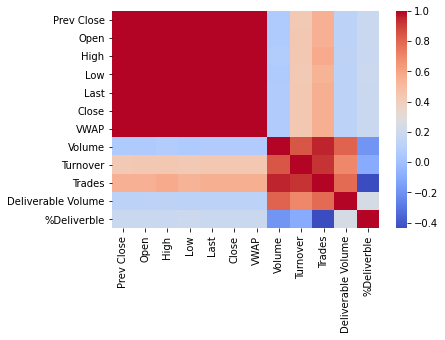

In [10]:
plt.figure()
sns.heatmap(data.corr(), cmap='coolwarm')
plt.show()

In [16]:
#Correlation with output variable
cor_target = abs(corr["Close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.9]
relevant_features

Prev Close    0.998163
Open          0.998866
High          0.999414
Low           0.999435
Last          0.999978
Close         1.000000
VWAP          0.999806
Name: Close, dtype: float64

In [7]:
features_to_drop = ['Date', 'Symbol', 'Series', 'Prev Close', 'Last', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
                       '%Deliverble']